<code style="background:none">Author: Iman Irajian</code> $\infty$

<table style="float:left">
    <thead>
        <tr>
            <th colspan=2>Contact</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Email:</td>
            <td><a style="text-decoration:none" href="mailto:iman.irajian@gmail.com?subject=Github machine-learning repository"><code style="color:darkblue; background:none;">iman.irajian@gmail.com</code></a></td>
        </tr>
        <tr>
            <td>LinkedIn:</td>
            <td><a style="text-decoration:none" href="https://www.linkedin.com/in/imanirajian/"><code style="color:darkblue; background:none;">linkedin.com/in/imanirajian</code></a></td>
        </tr>        
    </tbody>
</table>

> **"Happiness is not something you postpone for the future; it is something you design for the present."** -- Jim Rohn

> **"You cannot change your destination overnight, but you can change your direction overnight."** -- Jim Rohn

#### **Model:** Convolutional *AutoEncoder*
+ **Library:** PyTorch
+ **Device:** GPU or CPU
+ **Dependency:** `mnist_helper.py`

#### **Dataset:** *MNIST*

---
---

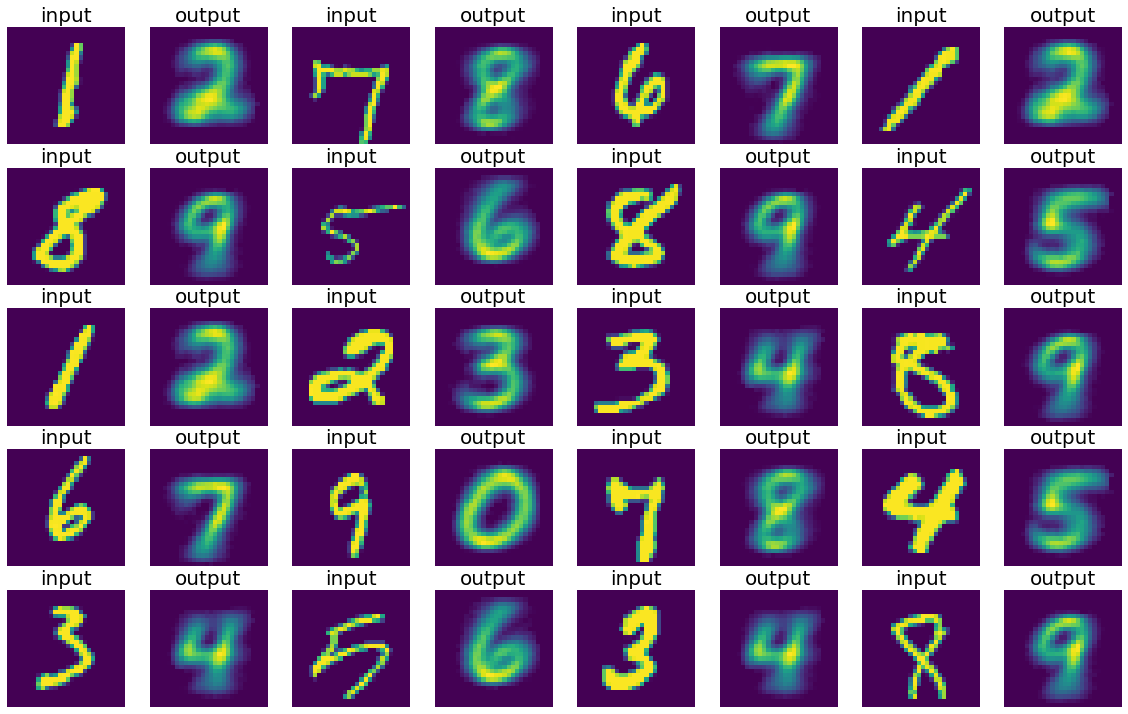

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ColabNotebooks/Projects/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/Projects


In [2]:
from Helpers.mnist_helper import get_data
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from typing import Tuple

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

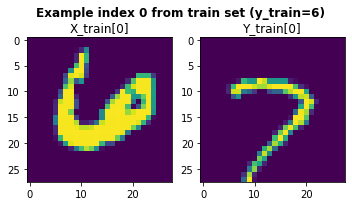

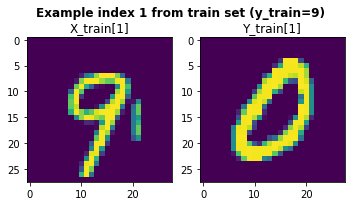

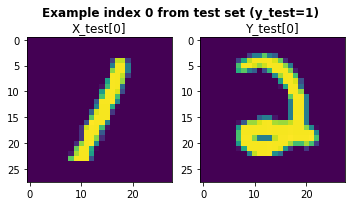

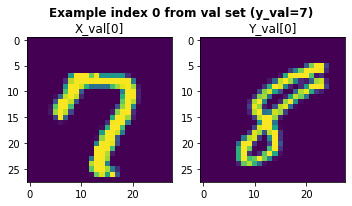

In [4]:
def show_example(target_set_name, idx):    
    plt.subplots(1, 2, figsize=(5.7, 3))
    plt.subplot(1, 2, 1)    
    plt.imshow(eval(f"X_{target_set_name}[idx]"))    
    plt.title(f"X_{target_set_name}[{idx}]")
    plt.subplot(1, 2, 2)
    plt.imshow(eval(f"Y_{target_set_name}[idx]"))    
    plt.title(f"Y_{target_set_name}[{idx}]")
    plt.suptitle(f"Example index {str(idx)} from {target_set_name} set (y_{target_set_name}=" + str(eval(f"y_{target_set_name}[idx]")) + ")", fontweight="bold")
    plt.show()

show_example("train", idx=0)
show_example("train", idx=1)
show_example("test", idx=0)
show_example("val", idx=0)

In [5]:
print("Shapes:")
print("\ttrain>")
print("\t\tX_train:", X_train.shape)
print("\t\tY_train:", Y_train.shape)
print("\t\ty_train:", y_train.shape)
print("\ttest>")
print("\t\tX_test:", X_test.shape)
print("\t\tY_test:", Y_test.shape)
print("\t\ty_test:", y_test.shape)
print("\tval>")
print("\t\tX_val:", X_val.shape)
print("\t\tY_val:", Y_val.shape)
print("\t\ty_val:", y_val.shape)

Shapes:
	train>
		X_train: (50400, 28, 28)
		Y_train: (50400, 28, 28)
		y_train: (50400,)
	test>
		X_test: (14000, 28, 28)
		Y_test: (14000, 28, 28)
		y_test: (14000,)
	val>
		X_val: (5600, 28, 28)
		Y_val: (5600, 28, 28)
		y_val: (5600,)


In [6]:
class Encoder(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()
        
        # CONVOLUTIONAL
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        # FLATTEN
        self.flatten = nn.Flatten(start_dim=1)

        # LINEAR
        self.linear = nn.Sequential(
            nn.Linear(3 * 3 * 64, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_size)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        # UNFLATTEN
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 3, 3))

        # CONVOLUTIONAL_TRANSPOSE
        self.convtranspose = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.convtranspose(x)
        x = torch.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
def train_epoch(autoencoder, device, dataloader, loss_fn, optimizer):
    autoencoder.train()
    train_loss = []
    for b, image_batch in enumerate(dataloader):
        image_batch_X = image_batch[0].unsqueeze(1).to(device)
        image_batch_Y = image_batch[1].unsqueeze(1).to(device)
        decoded_data = autoencoder(image_batch_X)
        loss = loss_fn(decoded_data, image_batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (b+1)%10==0:
            print(f"\t train loss on {b+1}-th batch: %f" % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def test_epoch(autoencoder, device, dataloader, loss_fn):
    autoencoder.eval()
    with torch.no_grad(): 
        conc_out = []
        conc_label = []
        for b, image_batch in enumerate(dataloader):
            image_batch_X = image_batch[0].unsqueeze(1).to(device)
            image_batch_Y = image_batch[1].unsqueeze(1).to(device)
            decoded_data = autoencoder(image_batch_X)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch_Y.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def plot_outputs(autoencoder, n=40):
    plt.figure(figsize=(6, 2))
    t_idx = np.random.randint(0, X_test.shape[0], n)

    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)        
    plt.suptitle("Random inputs", fontweight="bold")       
    plt.show() 

    plt.figure(figsize=(6, 2))
    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
         rec_img = autoencoder(img)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)        
    plt.suptitle("Outputs", fontweight="bold")      
    plt.show() 

In [9]:
class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [10]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)

val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [11]:
latent_size = 8
lr = 0.001
weight_decay=1e-05

autoencoder = AutoEncoder(latent_size)
params = [{"params": autoencoder.parameters()}]
optim = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.MSELoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")
autoencoder.to(device)

Device: cpu


AutoEncoder(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=576, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=576, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3)

---
	 train loss on 10-th batch: 0.204893
	 train loss on 20-th batch: 0.171037
	 train loss on 30-th batch: 0.150210
	 train loss on 40-th batch: 0.134676
	 train loss on 50-th batch: 0.121584
	 train loss on 60-th batch: 0.111602
	 train loss on 70-th batch: 0.104551
	 train loss on 80-th batch: 0.097098
	 train loss on 90-th batch: 0.091418

 Epoch 1/15 	 train loss 0.1361817568540573 	 val loss 0.08754673600196838



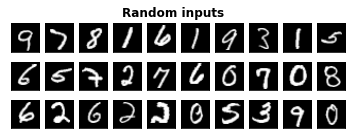

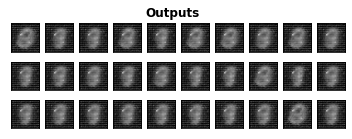

---
	 train loss on 10-th batch: 0.083097
	 train loss on 20-th batch: 0.080461
	 train loss on 30-th batch: 0.076922
	 train loss on 40-th batch: 0.073018
	 train loss on 50-th batch: 0.069963
	 train loss on 60-th batch: 0.069549
	 train loss on 70-th batch: 0.067698
	 train loss on 80-th batch: 0.066255
	 train loss on 90-th batch: 0.065049

 Epoch 2/15 	 train loss 0.07295782119035721 	 val loss 0.06355573236942291



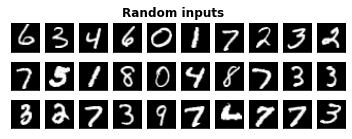

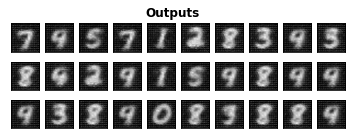

---
	 train loss on 10-th batch: 0.063039
	 train loss on 20-th batch: 0.062588
	 train loss on 30-th batch: 0.060841
	 train loss on 40-th batch: 0.060739
	 train loss on 50-th batch: 0.060612
	 train loss on 60-th batch: 0.059928
	 train loss on 70-th batch: 0.058110
	 train loss on 80-th batch: 0.060069
	 train loss on 90-th batch: 0.059320

 Epoch 3/15 	 train loss 0.060455042868852615 	 val loss 0.05838634446263313



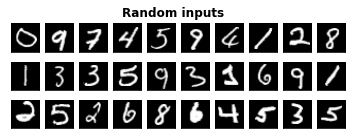

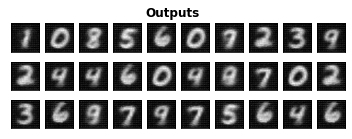

---
	 train loss on 10-th batch: 0.058225
	 train loss on 20-th batch: 0.058271
	 train loss on 30-th batch: 0.058194
	 train loss on 40-th batch: 0.057487
	 train loss on 50-th batch: 0.055957
	 train loss on 60-th batch: 0.058483
	 train loss on 70-th batch: 0.056792
	 train loss on 80-th batch: 0.056798
	 train loss on 90-th batch: 0.057155

 Epoch 4/15 	 train loss 0.057318009436130524 	 val loss 0.056509830057621



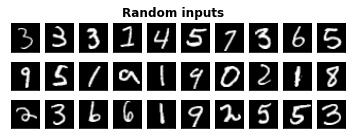

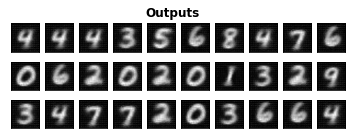

---
	 train loss on 10-th batch: 0.057055
	 train loss on 20-th batch: 0.057247
	 train loss on 30-th batch: 0.057065
	 train loss on 40-th batch: 0.056148
	 train loss on 50-th batch: 0.055293
	 train loss on 60-th batch: 0.055342
	 train loss on 70-th batch: 0.055590
	 train loss on 80-th batch: 0.056738
	 train loss on 90-th batch: 0.055477

 Epoch 5/15 	 train loss 0.05608633905649185 	 val loss 0.055966395884752274



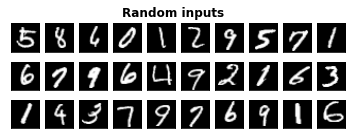

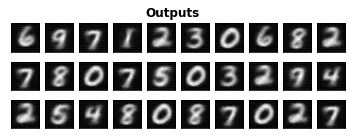

---
	 train loss on 10-th batch: 0.054808
	 train loss on 20-th batch: 0.055577
	 train loss on 30-th batch: 0.054454
	 train loss on 40-th batch: 0.054407
	 train loss on 50-th batch: 0.055089
	 train loss on 60-th batch: 0.056171
	 train loss on 70-th batch: 0.055127
	 train loss on 80-th batch: 0.055031
	 train loss on 90-th batch: 0.056313

 Epoch 6/15 	 train loss 0.05546913668513298 	 val loss 0.05540624260902405



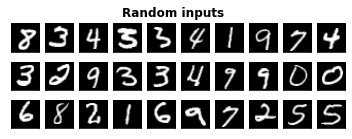

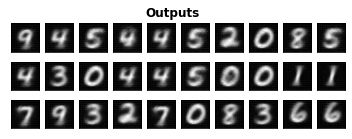

---
	 train loss on 10-th batch: 0.054722
	 train loss on 20-th batch: 0.055109
	 train loss on 30-th batch: 0.056296
	 train loss on 40-th batch: 0.054937
	 train loss on 50-th batch: 0.055828
	 train loss on 60-th batch: 0.054342
	 train loss on 70-th batch: 0.055669
	 train loss on 80-th batch: 0.055153
	 train loss on 90-th batch: 0.054979

 Epoch 7/15 	 train loss 0.05510814115405083 	 val loss 0.055106744170188904



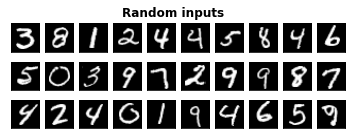

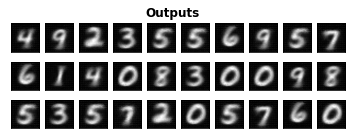

---
	 train loss on 10-th batch: 0.053857
	 train loss on 20-th batch: 0.055085
	 train loss on 30-th batch: 0.055639
	 train loss on 40-th batch: 0.054830
	 train loss on 50-th batch: 0.053636
	 train loss on 60-th batch: 0.054336
	 train loss on 70-th batch: 0.053905
	 train loss on 80-th batch: 0.053583
	 train loss on 90-th batch: 0.055953

 Epoch 8/15 	 train loss 0.054831650108098984 	 val loss 0.055018212646245956



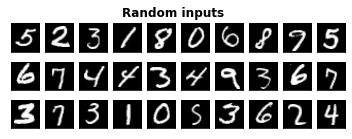

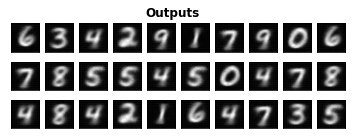

---
	 train loss on 10-th batch: 0.054621
	 train loss on 20-th batch: 0.054812
	 train loss on 30-th batch: 0.056101
	 train loss on 40-th batch: 0.054523
	 train loss on 50-th batch: 0.055739
	 train loss on 60-th batch: 0.053843
	 train loss on 70-th batch: 0.054177
	 train loss on 80-th batch: 0.054900
	 train loss on 90-th batch: 0.054388

 Epoch 9/15 	 train loss 0.05470242723822594 	 val loss 0.05494241788983345



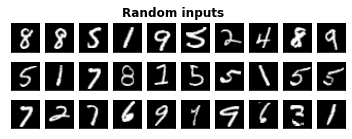

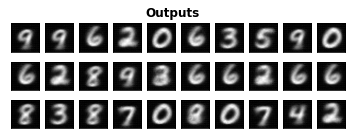

---
	 train loss on 10-th batch: 0.054687
	 train loss on 20-th batch: 0.054305
	 train loss on 30-th batch: 0.055173
	 train loss on 40-th batch: 0.054679
	 train loss on 50-th batch: 0.055124
	 train loss on 60-th batch: 0.054839
	 train loss on 70-th batch: 0.055478
	 train loss on 80-th batch: 0.055140
	 train loss on 90-th batch: 0.054915

 Epoch 10/15 	 train loss 0.05455000326037407 	 val loss 0.05480536073446274



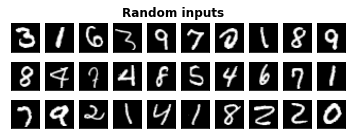

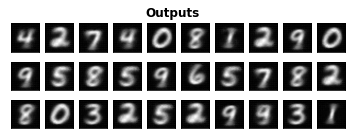

---
	 train loss on 10-th batch: 0.053749
	 train loss on 20-th batch: 0.053389
	 train loss on 30-th batch: 0.054766
	 train loss on 40-th batch: 0.052893
	 train loss on 50-th batch: 0.054301
	 train loss on 60-th batch: 0.053394
	 train loss on 70-th batch: 0.054181
	 train loss on 80-th batch: 0.054865
	 train loss on 90-th batch: 0.054375

 Epoch 11/15 	 train loss 0.0544491671025753 	 val loss 0.0547269731760025



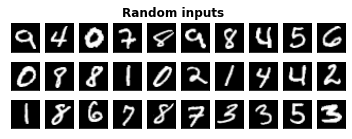

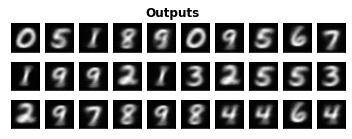

---
	 train loss on 10-th batch: 0.053683
	 train loss on 20-th batch: 0.054545
	 train loss on 30-th batch: 0.054368
	 train loss on 40-th batch: 0.053072
	 train loss on 50-th batch: 0.054806
	 train loss on 60-th batch: 0.053411
	 train loss on 70-th batch: 0.054866
	 train loss on 80-th batch: 0.055097
	 train loss on 90-th batch: 0.054800

 Epoch 12/15 	 train loss 0.05436662584543228 	 val loss 0.05477755144238472



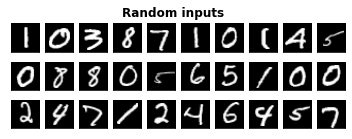

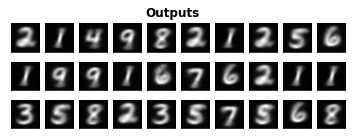

---
	 train loss on 10-th batch: 0.053796
	 train loss on 20-th batch: 0.054619
	 train loss on 30-th batch: 0.053252
	 train loss on 40-th batch: 0.053020
	 train loss on 50-th batch: 0.055906
	 train loss on 60-th batch: 0.053975
	 train loss on 70-th batch: 0.053775
	 train loss on 80-th batch: 0.054659
	 train loss on 90-th batch: 0.055050

 Epoch 13/15 	 train loss 0.054333336651325226 	 val loss 0.054816633462905884



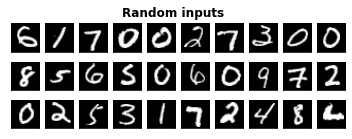

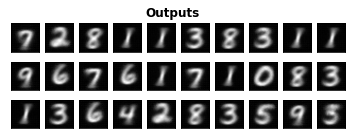

---
	 train loss on 10-th batch: 0.054533
	 train loss on 20-th batch: 0.053068
	 train loss on 30-th batch: 0.055189
	 train loss on 40-th batch: 0.055425
	 train loss on 50-th batch: 0.055062
	 train loss on 60-th batch: 0.055786
	 train loss on 70-th batch: 0.054593
	 train loss on 80-th batch: 0.055783
	 train loss on 90-th batch: 0.054754

 Epoch 14/15 	 train loss 0.05424586310982704 	 val loss 0.05465608462691307



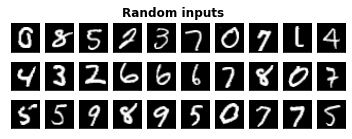

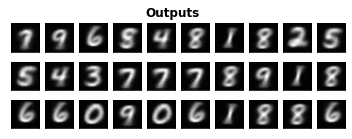

---
	 train loss on 10-th batch: 0.053870
	 train loss on 20-th batch: 0.052727
	 train loss on 30-th batch: 0.053859
	 train loss on 40-th batch: 0.053931
	 train loss on 50-th batch: 0.054405
	 train loss on 60-th batch: 0.054090
	 train loss on 70-th batch: 0.054502
	 train loss on 80-th batch: 0.053809
	 train loss on 90-th batch: 0.053964

 Epoch 15/15 	 train loss 0.0541788786649704 	 val loss 0.054693009704351425



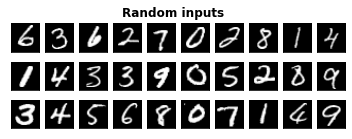

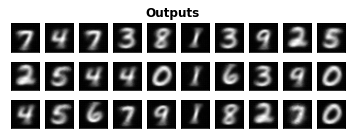

In [12]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

num_epochs = 15

loss_data = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   print("---")
   train_loss = train_epoch(autoencoder, device, train_dataloader, loss_fn, optim)
   val_loss = test_epoch(autoencoder, device, val_dataloader, loss_fn)
   print('\n Epoch {}/{} \t train loss {} \t val loss {}\n'.format(epoch + 1, num_epochs, train_loss, val_loss))
   loss_data['train_loss'].append(train_loss)
   loss_data['val_loss'].append(val_loss)
   plot_outputs(autoencoder, n=30)

In [13]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
print("Model's state_dict:")
for param_tensor in autoencoder.state_dict():
    print(param_tensor, "\t", autoencoder.state_dict()[param_tensor].size())

torch.save(autoencoder.state_dict(), "./trained_model")

model = AutoEncoder(latent_size)
model.load_state_dict(torch.load("./trained_model"))
model.eval()

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

Model's state_dict:
encoder.cnn.0.weight 	 torch.Size([16, 1, 3, 3])
encoder.cnn.0.bias 	 torch.Size([16])
encoder.cnn.2.weight 	 torch.Size([32, 16, 3, 3])
encoder.cnn.2.bias 	 torch.Size([32])
encoder.cnn.3.weight 	 torch.Size([32])
encoder.cnn.3.bias 	 torch.Size([32])
encoder.cnn.3.running_mean 	 torch.Size([32])
encoder.cnn.3.running_var 	 torch.Size([32])
encoder.cnn.3.num_batches_tracked 	 torch.Size([])
encoder.cnn.5.weight 	 torch.Size([64, 32, 3, 3])
encoder.cnn.5.bias 	 torch.Size([64])
encoder.linear.0.weight 	 torch.Size([128, 576])
encoder.linear.0.bias 	 torch.Size([128])
encoder.linear.2.weight 	 torch.Size([8, 128])
encoder.linear.2.bias 	 torch.Size([8])
decoder.linear.0.weight 	 torch.Size([128, 8])
decoder.linear.0.bias 	 torch.Size([128])
decoder.linear.2.weight 	 torch.Size([576, 128])
decoder.linear.2.bias 	 torch.Size([576])
decoder.convtranspose.0.weight 	 torch.Size([64, 32, 3, 3])
decoder.convtranspose.0.bias 	 torch.Size([32])
decoder.convtranspose.1.weight 

AutoEncoder(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=576, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=576, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3)

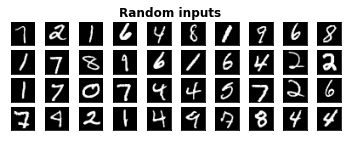

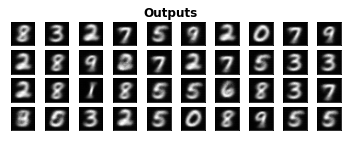

In [14]:
plot_outputs(autoencoder, n=40)

&#8718;

---

<code style="background:none">Author: Iman Irajian</code> $\infty$

<table style="float:left">
    <thead>
        <tr>
            <th colspan=2>Contact</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Email:</td>
            <td><a style="text-decoration:none" href="mailto:iman.irajian@gmail.com?subject=Github machine-learning repository"><code style="color:darkblue; background:none;">iman.irajian@gmail.com</code></a></td>
        </tr>
        <tr>
            <td>LinkedIn:</td>
            <td><a style="text-decoration:none" href="https://www.linkedin.com/in/imanirajian/"><code style="color:darkblue; background:none;">linkedin.com/in/imanirajian</code></a></td>
        </tr>        
    </tbody>
</table>